In [1]:
from plot_utils import plot_loss, plot_histogram_balance_of_dataset
from model import Model
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

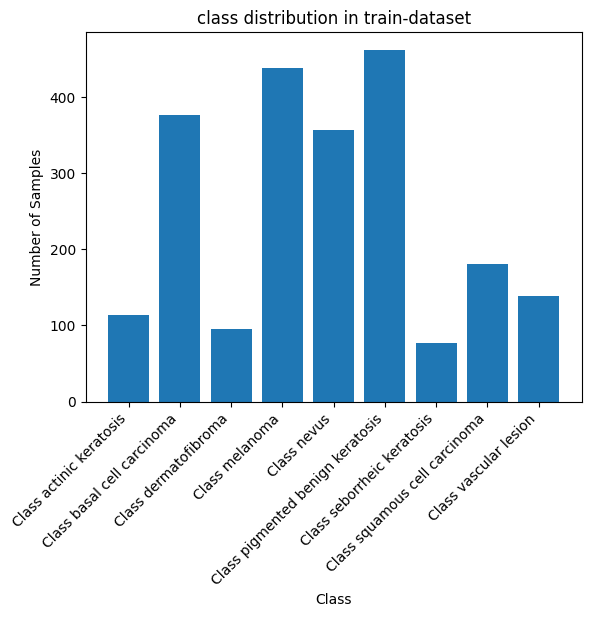

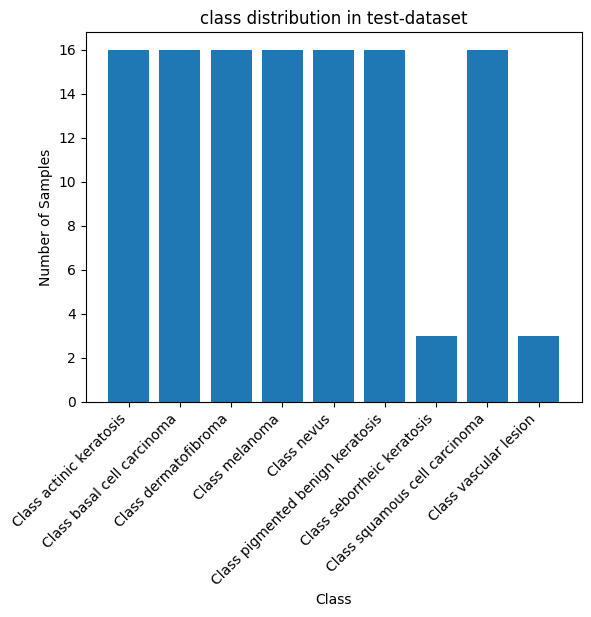

In [2]:
train_val_split_ratio = 0.9
batch_size = 16
learning_rate = 0.0001
patience_early_stopping = 7
patience_reduce_learning_rate = 2
train_dir = "Skin cancer ISIC The International Skin Imaging Collaboration/Train"
test_dir = "Skin cancer ISIC The International Skin Imaging Collaboration/Test"

model = Model(learning_rate=learning_rate, batch_size=batch_size, patience_early_stopping=patience_early_stopping,
              patience_reduce_learning_rate=patience_reduce_learning_rate, train_dir=train_dir, test_dir=test_dir,
              train_val_split_ratio=train_val_split_ratio)

plot_histogram_balance_of_dataset(train_dir, "class distribution in train-dataset")
plot_histogram_balance_of_dataset(test_dir, "class distribution in test-dataset")

In [ ]:
train_losses, val_losses = model.train_model(50)

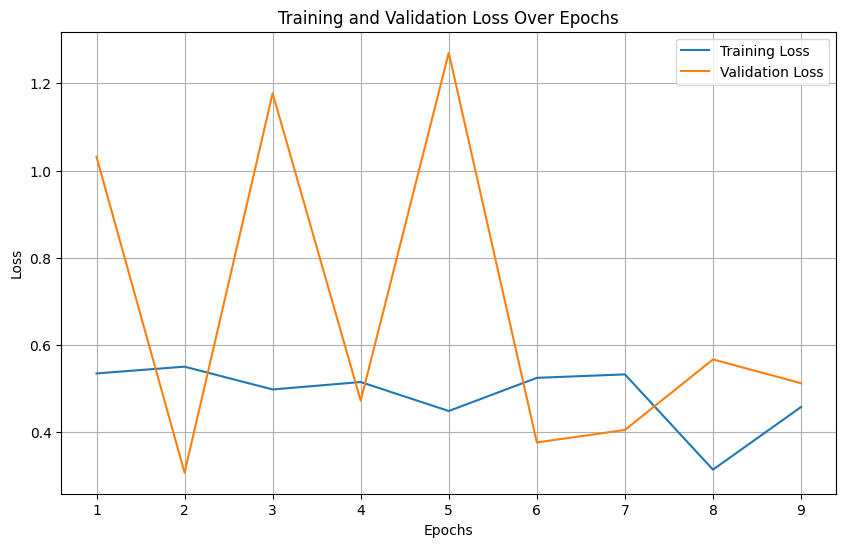

In [4]:
plot_loss(train_losses, val_losses)

In [5]:
true_labels, predicted_labels, confidence_values = model.evaluate()
print("F1-score: " + f1_score(true_labels, predicted_labels, average='macro'))
print("Recall: " + recall_score(true_labels, predicted_labels, average='macro'))
print("Precision: " + precision_score(true_labels, predicted_labels, average='macro'))
print("Accuracy: " + accuracy_score(true_labels, predicted_labels))

Test Accuracy: 0.8317


([0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [6]:
import torch

torch.save(model.model.state_dict(), "model2.pth")